# Multi-channel Representation for Images - [MCRQI](https://www.overleaf.com/project/61911febed45e965f929d7c0#cite.sun2011multi)



This image representation technique bases on [FRQI](https://link.springer.com/content/pdf/10.1007/s11128-010-0177-y.pdf). Image is encoded as follows:

$ | I(\theta) \rangle = \frac{1}{2^{n+1}}\sum_{i=0}^{2^{2n}-1} | c_{RGB\alpha}^i \rangle \bigotimes | i \rangle $, where

$| c_{RGB\alpha}^i \rangle $ - continuose angle intensity representation of the $i_{th}$ pixel

Step 0: dependencies import

In [2]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, Aer
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
import math
from qiskit.circuit.library.standard_gates.ry import RYGate

Step 1: image generating

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


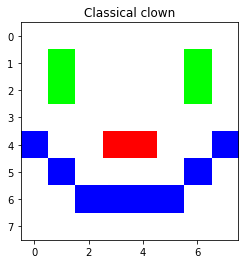

In [6]:
image = np.zeros((8,8,3))
image[:,:,0] = np.array(
           [255, 255, 255, 255, 255, 255, 255, 255,
            255,   0, 255, 255, 255, 255,   0, 255,
            255,   0, 255, 255, 255, 255,   0, 255,
            255, 255, 255, 255, 255, 255, 255, 255,
              0, 255, 255, 255, 255, 255, 255,   0,
            255,   0, 255, 255, 255, 255,   0, 255,
            255, 255, 0,   0,   0,   0, 255, 255,
            255, 255, 255, 255, 255, 255, 255, 255]).reshape(8,8)

image[:,:,1] = np.array(
           [255, 255, 255, 255, 255, 255, 255, 255,
            255, 255, 255, 255, 255, 255, 255, 255,
            255, 255, 255, 255, 255, 255, 255, 255,
            255, 255, 255, 255, 255, 255, 255, 255,
              0, 255, 255,   0,   0, 255, 255,   0,
            255,   0, 255, 255, 255, 255,   0, 255,
            255, 255, 0,   0,   0,   0,255, 255,
            255, 255, 255, 255, 255, 255, 255, 255]).reshape(8,8)

image[:,:,2] = np.array(
           [255, 255, 255, 255, 255, 255, 255, 255,
            255,   0, 255, 255, 255, 255,   0, 255,
            255,   0, 255, 255, 255, 255,   0, 255,
            255, 255, 255, 255, 255, 255, 255, 255,
            255, 255, 255,   0,   0, 255, 255, 255,
            255, 255, 255, 255, 255, 255, 255, 255,
            255, 255, 255, 255, 255, 255, 255, 255,
            255, 255, 255, 255, 255, 255, 255, 255]).reshape(8,8)

plt.imshow(image.reshape(8,8,3))
plt.title('Classical clown')
plt.show()

Step 2: MCRQI image encoding

In [7]:
def params(image):
    xqbits = math.log(image.shape[0],2)
    yqbits = math.log(image.shape[1],2)
    return int(xqbits), int(yqbits)
    
def rgb_circ(image):
    xqbit, yqbit = params(image)
    qr = QuantumRegister(xqbit + yqbit + 3) #3 stands for RGB qubits
    # color = qr[xqbit + yqbit:]
    # coordinate = qr[:xqbit + yqbit]
    cr = ClassicalRegister(xqbit + yqbit + 3, 'c')
    qc = QuantumCircuit(qr, cr)
    
    for k in range(int(np.floor((xqbit + yqbit)/2))):
        qc.swap(k,xqbit + yqbit - 1 - k)
        
    for i in range(xqbit + yqbit):
        qc.h(i)
    
    for layer_num, input_im in enumerate(image.T):
        input_im = input_im.flatten()
        input_im = np.interp(input_im, (0, 255), (0, np.pi/2))
        
        for i, pixel in enumerate(input_im):
            arr = list(range(xqbit + yqbit))
            arr.append(int(xqbit + yqbit + layer_num))
            cMry = RYGate(2*pixel).control(xqbit + yqbit)
            
            to_not = "{0:b}".format(i).zfill(xqbit + yqbit)
            for j, bit in enumerate(to_not):
                if int(bit):
                    qc.x(j)
            qc.barrier()
            qc.append(cMry, arr)  

            if i!=len(input_im)-1 or layer_num!=2:
                for j, bit in enumerate(to_not):
                    if int(bit):
                        qc.x(j)
                qc.barrier()
    
    for k in range(int(np.floor((xqbit + yqbit)/2))):
        qc.swap(k, xqbit + yqbit - 1 - k)
    
    qc.swap(-1, -3)

    qc.barrier()
    for i in range(xqbit + yqbit + 3):
        qc.measure(i, i)
    
    return qc


Step 3: circuit execution

In [8]:
def run_qc(qc, shots=1000):    
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc, shots=shots)
    result = aer_sim.run(qobj).result()
    counts = result.get_counts(qc)
    return counts

In [11]:
qc = rgb_circ(image)
counts = run_qc(qc)

Step 4: measurments interpretation

In [12]:
def reconstruct_rgb(image, counts, to_print=True):
    output_ims = []
    for layer_num, input_im in enumerate(image.T):
        input_im = input_im.flatten()
        nums = []
        for iter in range(len(input_im)):
            flag = 0
            num = []
            for item in counts.items():
                if int(item[0][3:], 2)==iter:
                    num.append((int(item[0][layer_num], 2), item[1]))
            nums.append(num)
        for l, num in enumerate(nums):
            my_set = {x[0] for x in num}
            nums[l] = [(i,sum(x[1] for x in num if x[0] == i)) for i in my_set]
        colors = []
        for num in nums:
            if len(num)==2:
                if num[0][0] == 0:
                    color = np.arccos((num[0][1]/(num[0][1]+num[1][1]))**(1/2))
                    colors.append(color)
                else:
                    color = np.arccos((num[1][1]/(num[0][1]+num[1][1]))**(1/2))
                    colors.append(color)
            else:
                if num[0][0] == 0:
                    colors.append(0)
                else:
                    colors.append(np.pi/2)
        output_im = np.interp(colors, (0, np.pi/2), (0, 255)).astype(int)
        if to_print:
            print(output_im, '\n', (image.T)[layer_num].copy().flatten())
        output_ims.append(output_im.reshape(image[:,:,0].shape))
    
    return np.array(output_ims).T

Classical and quantum representation are similar. That sows the correctness of encoding

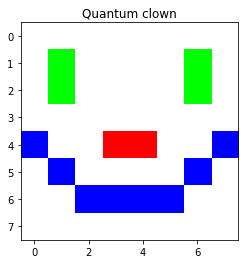

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


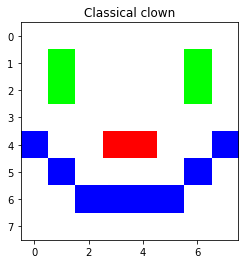

In [13]:
output_ims = reconstruct_rgb(image, counts, to_print = False)
plt.imshow(output_ims)
plt.title('Quantum clown')
plt.show()
plt.title('Classical clown')
plt.imshow(image)
plt.show()

### Now with image built from not pure RGB intensities. Classical image generation:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


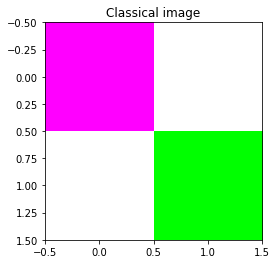

In [14]:
image = np.zeros((2,2,3))
image[:,:,0] = np.array(
           [255, 10,
            250,   0]).reshape(2,2)

image[:,:,1] = np.array(
           [0, 100,
            150, 255]).reshape(2,2)

image[:,:,2] = np.array(
           [255, 200,
            10,   0]).reshape(2,2)

plt.imshow(image.reshape(2,2,3))
plt.title('Classical image')
plt.show()

Circuit run and measurments. Despite images look different the channel-wise comparioson shows the simmilarity of imtensities

[255 249  10   0] 
 [255. 250.  10.   0.]
[  0 149 100 255] 
 [  0. 150. 100. 255.]
[255   9 201   0] 
 [255.  10. 200.   0.]


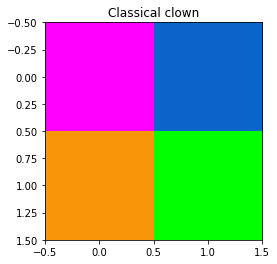

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


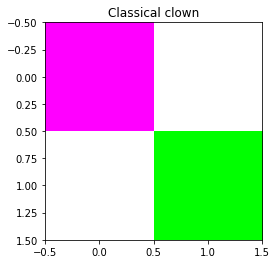

In [15]:
qc = rgb_circ(image)
counts = run_qc(qc, shots=100000)
output_ims = reconstruct_rgb(image, counts, to_print=True)
plt.title('Classical clown')
plt.imshow(output_ims)
plt.show()
plt.title('Classical clown')
plt.imshow(image)
plt.show()